In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
adsorbate = 'CO'
target_energy = -0.67  # eV
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import json
import numpy as np


with open('../../pull_data/%s/%s.json' % (adsorbate, adsorbate), 'r') as file_handle:
    docs = json.load(file_handle)
random.Random(42).shuffle(docs)


def parse_docs(docs):
    '''
    Our testing framework needs us to divide information into features, labels, and surfaces.
    This function will convert a list of docs/dictionaries into these things.
    
    Arg:
        docs    A list of dictionaries from `gaspy.gasdb.get_adsorption_docs`
    Returns:
        features    ...just the `docs` arg
        labels      A list of the 'energy' keys in `docs`
        surfaces    A list of 4-tuples indicating the surfaces of `docs
    '''
    features = docs
    labels = [doc['energy'] for doc in docs]
    surfaces = [(doc['mpid'], doc['miller'], doc['shift'], doc['top']) for doc in docs]
    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_docs(docs[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_docs(docs[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
import warnings

import os
import sys
os.environ['PYTHONPATH'] = '/home/jovyan/GASpy:/home/jovyan/GASpy/GASpy_regressions'
sys.path.append('/home/jovyan/GASpy')
sys.path.append('/home/jovyan/GASpy/GASpy_regressions')

sys.path.append('../../..')
from src.discoverers.adsorption.gaussian import GaussianDiscoverer
from src.discoverers.adsorption.models import TPOT
from src.discoverers.adsorption.values import calc_co2rr_activities


# The GASpy fingerprinter will be yelling at us a lot about missing data.
# Good to know in production, but also good to ignore here.
with warnings.catch_warnings():
    warnings.filterwarnings(message='We do not have any energy data for %s on ' % adsorbate, action='ignore')

    # Initialize
    model = TPOT()
    discoverer = GaussianDiscoverer(model=model,
                                    value_calculator=calc_co2rr_activities,
                                    target_energy=target_energy,
                                    quantile_cutoff=quantile_cutoff,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False  # Set to `False` only for warm starts
                                    )

## Run

In [ ]:
# The GASpy fingerprinter will be yelling at us a lot about missing data.
# Good to know in production, but also good to ignore here.
with warnings.catch_warnings():
    warnings.filterwarnings(message='You did not initialize the fingerprinter with the ', action='ignore')
    warnings.filterwarnings(message='We do not have any energy data for %s on ' % adsorbate, action='ignore')

    discoverer.simulate_discovery()

In [5]:
# Or load the last run
discoverer.load_last_run()

## Analyze

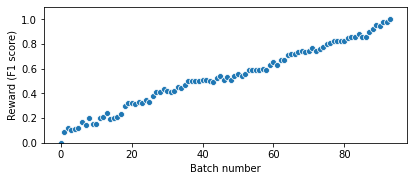

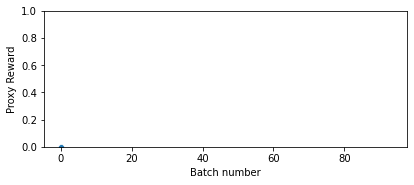

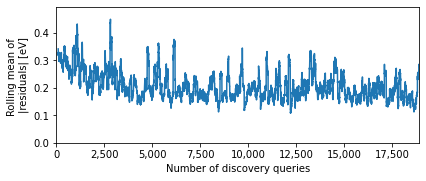

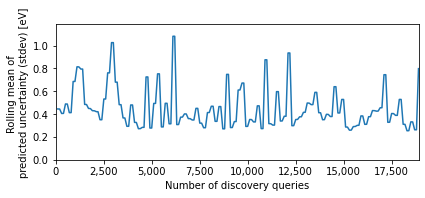

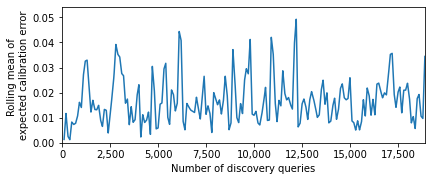

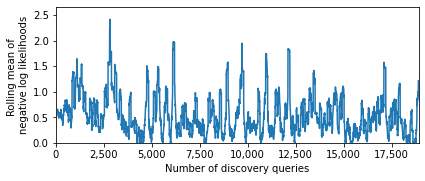

In [6]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)